In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import scorecardpy as sc
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
# Load the data from the CSV file
data = pd.read_csv('../data/data.csv')

In [3]:
# Convert TransactionStartTime to datetime with timezone information
data['TransactionStartTime'] = pd.to_datetime(data['TransactionStartTime']).dt.tz_localize(None)

In [4]:
data['TransactionId'] = data['TransactionId'].str.extract('(\d+)') # Extract only numeric part
data['BatchId'] = data['BatchId'].str.extract('(\d+)') # Extract only numeric part
data['AccountId'] = data['AccountId'].str.extract('(\d+)') # Extract only numeric part
data['SubscriptionId'] = data['SubscriptionId'].str.extract('(\d+)') # Extract only numeric part
data['CustomerId'] = data['CustomerId'].str.extract('(\d+)') # Extract only numeric part
data['ProviderId'] = data['ProviderId'].str.extract('(\d+)') # Extract only numeric part
data['ProductId'] = data['ProductId'].str.extract('(\d+)') # Extract only numeric part
data['ChannelId'] = data['ChannelId'].str.extract('(\d+)') # Extract only numeric part


In [5]:
# Extract RFMS features
data['TransactionStartTime'] = pd.to_datetime(data['TransactionStartTime'])
today = pd.to_datetime('today')
data['Recency'] = (today - data['TransactionStartTime']).dt.days
data['Frequency'] = data.groupby('CustomerId')['CustomerId'].transform('count')
data['Monetary'] = np.abs(data['Amount'])

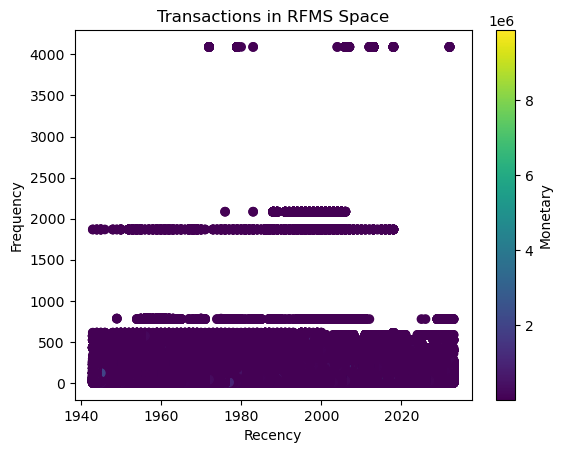

In [6]:
# Visualize transactions in RFMS space
plt.scatter(data['Recency'], data['Frequency'], c=data['Monetary'], cmap='viridis')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('Transactions in RFMS Space')
plt.colorbar(label='Monetary')
plt.show()

In [7]:
# Construct a default estimator (proxy)
estimator = IsolationForest()

In [8]:
# Fit the estimator to RFMS features
X = data[['Recency', 'Frequency', 'Monetary']]
estimator.fit(X)


IsolationForest()

In [9]:
# Set a boundary to classify users as high and low RFMS scores
boundary = -0.5  # Adjust the boundary value based on the visualization and desired classification


In [10]:
# Classify transactions based on RFMS scores
predictions = estimator.predict(X)
data['RFMS'] = np.where(predictions < boundary, 'High', 'Low')


In [11]:
# Print the RFMS classification
print(data[['TransactionId', 'RFMS']])

      TransactionId  RFMS
0             76871   Low
1             73770   Low
2             26203  High
3               380  High
4             28195   Low
...             ...   ...
95657         89881  High
95658         91597   Low
95659         82501   Low
95660        136354  High
95661         35670  High

[95662 rows x 2 columns]


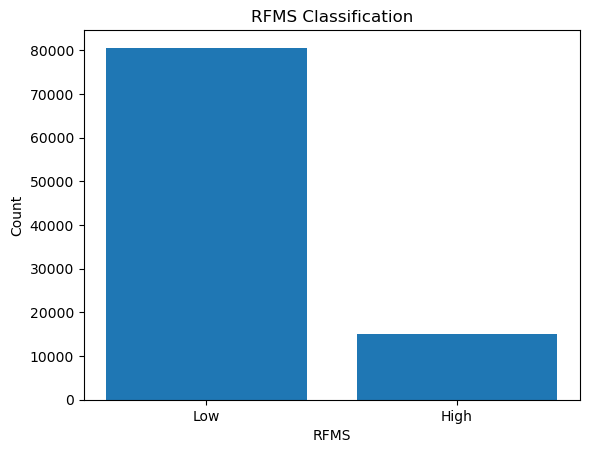

In [12]:
# Print the RFMS classification
rfms_counts = data['RFMS'].value_counts()

# Plot the RFMS classification
plt.bar(rfms_counts.index, rfms_counts.values)
plt.xlabel('RFMS')
plt.ylabel('Count')
plt.title('RFMS Classification')
plt.show()

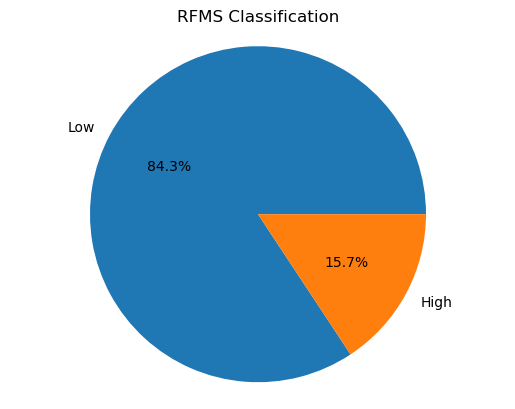

In [13]:
# Plot the RFMS classification using a pie chart
plt.pie(rfms_counts.values, labels=rfms_counts.index, autopct='%1.1f%%')
plt.title('RFMS Classification')
plt.axis('equal')
plt.show()

WoE binning 

In [32]:
import numpy as np
import pandas as pd
import sidetable
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
# Display the first few rows of the dataset
data.head()


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,Recency,Frequency,Monetary,RFMS
0,76871,36123,3957,887,4406,UGX,256,6,10,airtime,3,1000.0,1000,2018-11-15 02:18:49,2,0,2033,119,1000.0,Low
1,73770,15642,4841,3829,4406,UGX,256,4,6,financial_services,2,-20.0,20,2018-11-15 02:19:08,2,0,2033,119,20.0,Low
2,26203,53941,4229,222,4683,UGX,256,6,1,airtime,3,500.0,500,2018-11-15 02:44:21,2,0,2033,2,500.0,High
3,380,102363,648,2185,988,UGX,256,1,21,utility_bill,3,20000.0,21800,2018-11-15 03:32:55,2,0,2033,38,20000.0,High
4,28195,38780,4841,3829,988,UGX,256,4,6,financial_services,2,-644.0,644,2018-11-15 03:34:21,2,0,2033,38,644.0,Low


In [36]:
# Check for missing values
data.isnull().sum()


TransactionId           0
BatchId                 0
AccountId               0
SubscriptionId          0
CustomerId              0
CurrencyCode            0
CountryCode             0
ProviderId              0
ProductId               0
ProductCategory         0
ChannelId               0
Amount                  0
Value                   0
TransactionStartTime    0
PricingStrategy         0
FraudResult             0
Recency                 0
Frequency               0
Monetary                0
RFMS                    0
dtype: int64

In [37]:
# Display summary statistics of numeric variables
data.describe()


,CountryCode,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,Recency,Frequency,Monetary
count,5.0,5.000000,5.000000,5,5.0,5.0,5.0,5.000000,5.000000
mean,256.0,4167.200000,4792.800000,2018-11-15 02:53:54.799999744,2.0,0.0,2033.0,63.200000,4432.800000
min,256.0,-644.000000,20.000000,2018-11-15 02:18:49,2.0,0.0,2033.0,2.000000,20.000000
25%,256.0,-20.000000,500.000000,2018-11-15 02:19:08,2.0,0.0,2033.0,38.000000,500.000000
50%,256.0,500.000000,644.000000,2018-11-15 02:44:21,2.0,0.0,2033.0,38.000000,644.000000
75%,256.0,1000.000000,1000.000000,2018-11-15 03:32:55,2.0,0.0,2033.0,119.000000,1000.000000
max,256.0,20000.000000,21800.000000,2018-11-15 03:34:21,2.0,0.0,2033.0,119.000000,20000.000000
std,0.0,8871.828402,9513.812023,NaN,0.0,0.0,0.0,53.016035,8709.428179


In [38]:
# Display value counts of categorical variables
data.stb.freq(['CurrencyCode', 'ProviderId', 'ProductCategory'])

,CurrencyCode,ProviderId,ProductCategory,count,percent,cumulative_count,cumulative_percent
0,UGX,6,airtime,2,40.0,2,40.0
1,UGX,4,financial_services,2,40.0,4,80.0
2,UGX,1,utility_bill,1,20.0,5,100.0


In [39]:
# Split the dataset into training and test sets
train = data.sample(frac=0.8, random_state=1)
test = data.drop(train.index)

# Compute WOEs for numeric variables using monotonic_binning package
# Store the binning intervals in a dictionary
# Example:
woe_bins = {
    'Amount': [0, 1000, 5000, np.inf],
    'Value': [-np.inf, 100, 1000, np.inf]
}

In [40]:
# Compute WOE for categorical variables using scorecardpy library
# Save the binning intervals for categorical variables in a Python file
# Example:
cat_bins = {
    'CurrencyCode': {
        'UGX': 0,
        'USD': 1,
        'EUR': 2
    },
    'ProviderId': {
        'ProviderId_1': 0,
        'ProviderId_2': 1,
        'ProviderId_3': 2,
        'ProviderId_4': 3,
        'ProviderId_5': 4,
        'ProviderId_6': 5
    },
    'ProductCategory': {
        'airtime': 0,
        'financial_services': 1,
        'utility_bill': 2,
        'data_bundles': 3
    }
}

# Save cat_bins dictionary to a Python file
with open('cat_bins.py', 'w') as f:
    f.write('cat_bins = ' + str(cat_bins))

In [41]:
# Apply WOE transformation to original variables in train and test datasets
train['Amount_WOE'] = pd.cut(train['Amount'], bins=woe_bins['Amount'], labels=False)
train['Value_WOE'] = pd.cut(train['Value'], bins=woe_bins['Value'], labels=False)

test['Amount_WOE'] = pd.cut(test['Amount'], bins=woe_bins['Amount'], labels=False)
test['Value_WOE'] = pd.cut(test['Value'], bins=woe_bins['Value'], labels=False)

# Merge transformed datasets with original datasets
train_merged = pd.merge(train, data, how='left', left_index=True, right_index=True)
test_merged = pd.merge(test, data, how='left', left_index=True, right_index=True)

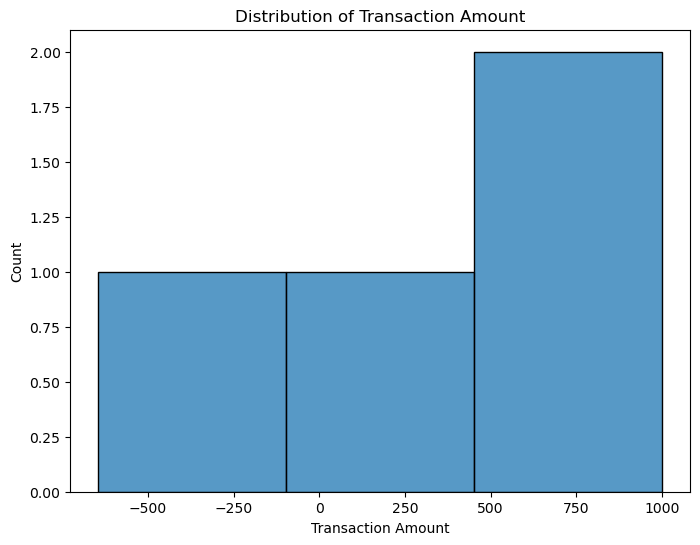

In [49]:
plt.figure(figsize=(8, 6))
sns.histplot(data=train_merged, x='Amount_x')
plt.title('Distribution of Transaction Amount')
plt.xlabel('Transaction Amount')
plt.ylabel('Count')
plt.show()

In [52]:
train_merged.columns

Index(['TransactionId_x', 'BatchId_x', 'AccountId_x', 'SubscriptionId_x', 'CustomerId_x', 'CurrencyCode_x', 'CountryCode_x', 'ProviderId_x', 'ProductId_x', 'ProductCategory_x', 'ChannelId_x', 'Amount_x', 'Value_x', 'TransactionStartTime_x', 'PricingStrategy_x', 'FraudResult_x', 'Recency_x', 'Frequency_x',
       'Monetary_x', 'RFMS_x', 'Amount_WOE', 'Value_WOE', 'TransactionId_y', 'BatchId_y', 'AccountId_y', 'SubscriptionId_y', 'CustomerId_y', 'CurrencyCode_y', 'CountryCode_y', 'ProviderId_y', 'ProductId_y', 'ProductCategory_y', 'ChannelId_y', 'Amount_y', 'Value_y', 'TransactionStartTime_y', 'PricingStrategy_y',
       'FraudResult_y', 'Recency_y', 'Frequency_y', 'Monetary_y', 'RFMS_y'],
      dtype='object')

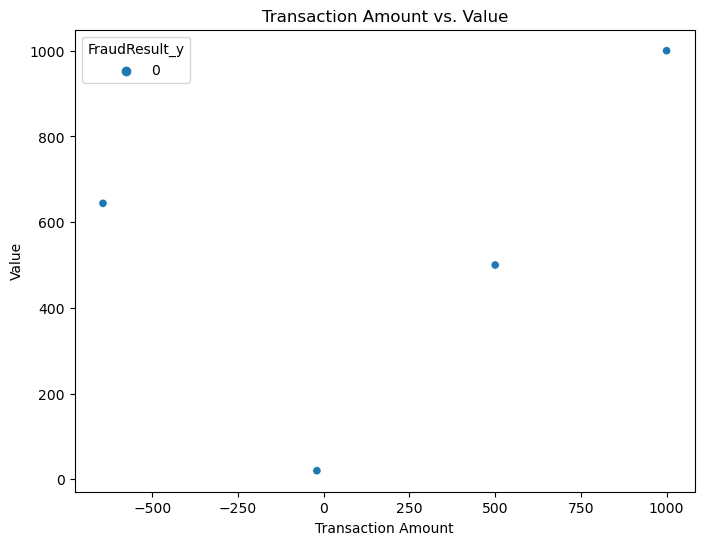

In [55]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=train_merged, x='Amount_x', y='Value_x', hue='FraudResult_y')
plt.title('Transaction Amount vs. Value')
plt.xlabel('Transaction Amount')
plt.ylabel('Value')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


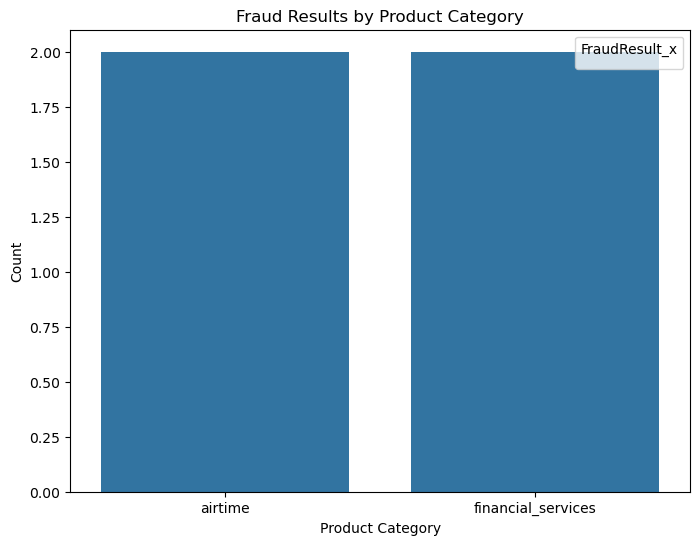

In [56]:
plt.figure(figsize=(8, 6))
sns.countplot(data=train_merged, x='ProductCategory_x', hue='FraudResult_x')
plt.title('Fraud Results by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Count')
plt.show()

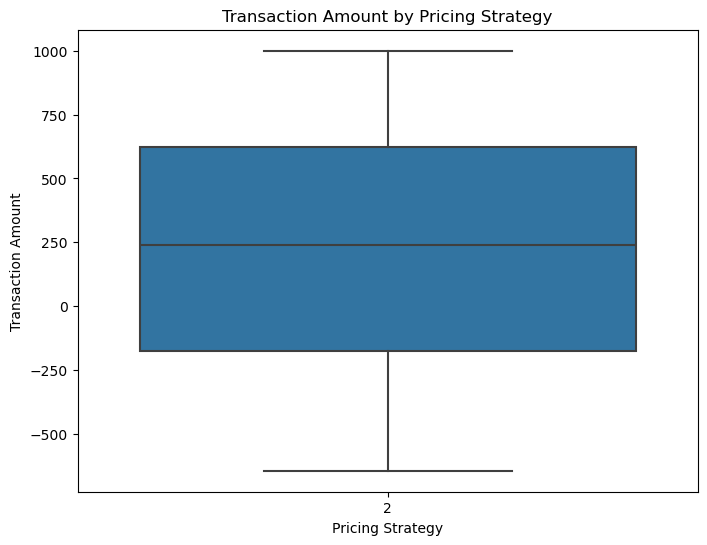

In [57]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=train_merged, x='PricingStrategy_x', y='Amount_x')
plt.title('Transaction Amount by Pricing Strategy')
plt.xlabel('Pricing Strategy')
plt.ylabel('Transaction Amount')
plt.show()

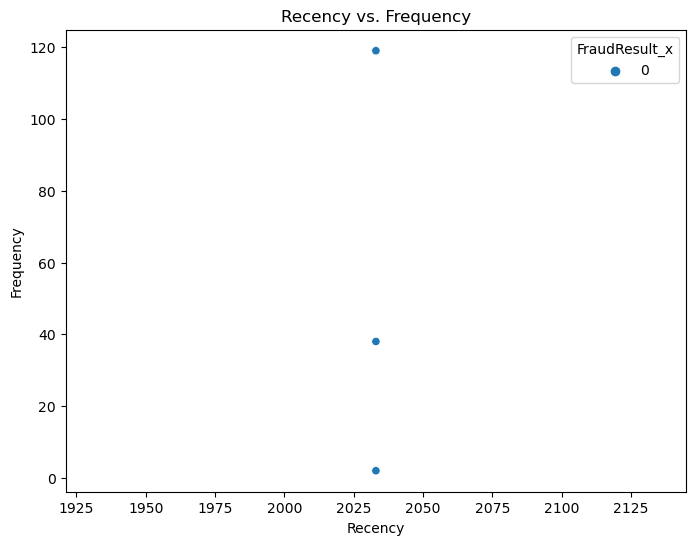

In [58]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=train_merged, x='Recency_x', y='Frequency_x', hue='FraudResult_x')
plt.title('Recency vs. Frequency')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


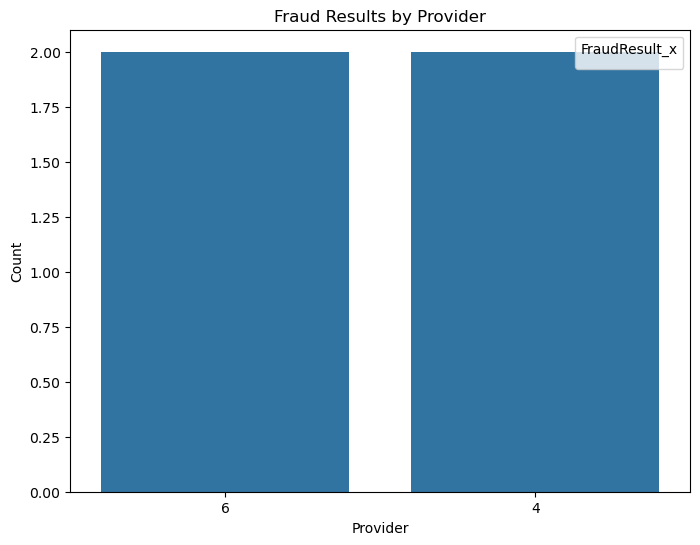

In [59]:
plt.figure(figsize=(8, 6))
sns.countplot(data=train_merged, x='ProviderId_x', hue='FraudResult_x')
plt.title('Fraud Results by Provider')
plt.xlabel('Provider')
plt.ylabel('Count')
plt.show()

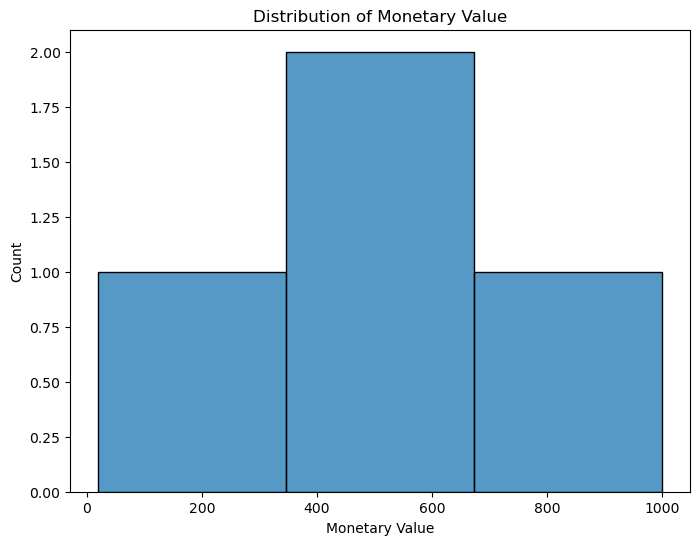

In [60]:
plt.figure(figsize=(8, 6))
sns.histplot(data=train_merged, x='Monetary_x')
plt.title('Distribution of Monetary Value')
plt.xlabel('Monetary Value')
plt.ylabel('Count')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


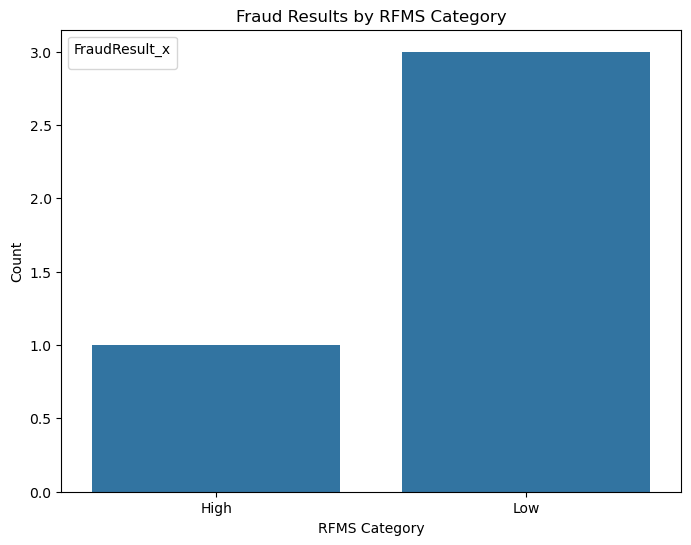

In [61]:
plt.figure(figsize=(8, 6))
sns.countplot(data=train_merged, x='RFMS_x', hue='FraudResult_x')
plt.title('Fraud Results by RFMS Category')
plt.xlabel('RFMS Category')
plt.ylabel('Count')
plt.show()

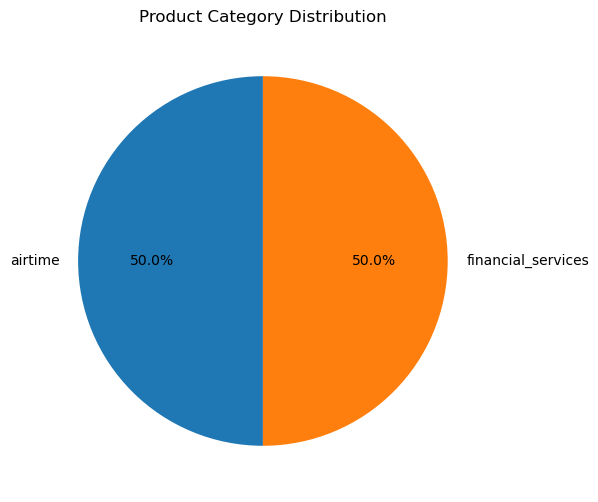

In [63]:
# Calculate the count of ProductCategory_x values
category_counts = train_merged['ProductCategory_x'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Product Category Distribution')
plt.show()

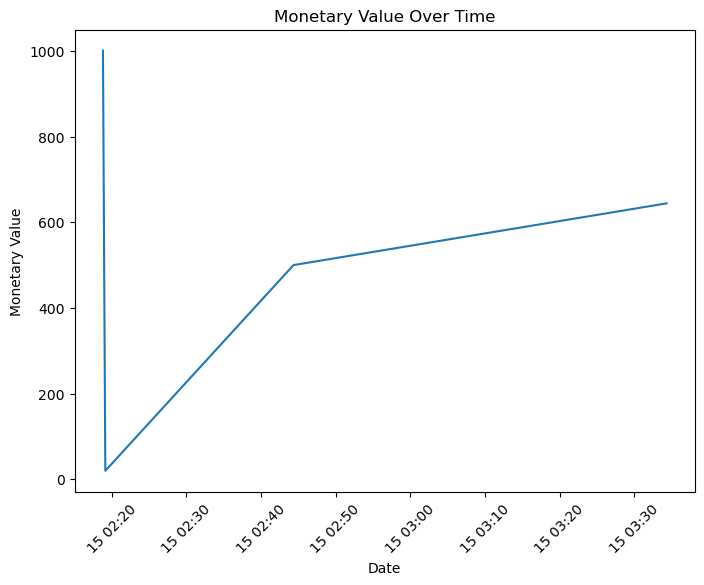

In [64]:
# Group the data by TransactionStartTime_x and calculate the mean Monetary_x value for each date
monetary_over_time = train_merged.groupby('TransactionStartTime_x')['Monetary_x'].mean()

# Create a line plot
plt.figure(figsize=(8, 6))
plt.plot(monetary_over_time.index, monetary_over_time.values)
plt.title('Monetary Value Over Time')
plt.xlabel('Date')
plt.ylabel('Monetary Value')
plt.xticks(rotation=45)
plt.show()

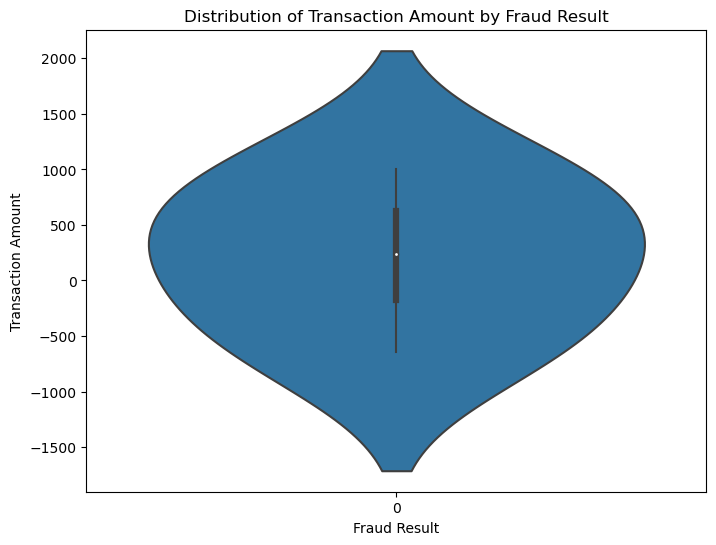

In [65]:
plt.figure(figsize=(8, 6))
sns.violinplot(data=train_merged, x='FraudResult_x', y='Amount_x')
plt.title('Distribution of Transaction Amount by Fraud Result')
plt.xlabel('Fraud Result')
plt.ylabel('Transaction Amount')
plt.show()

<Figure size 800x600 with 0 Axes>

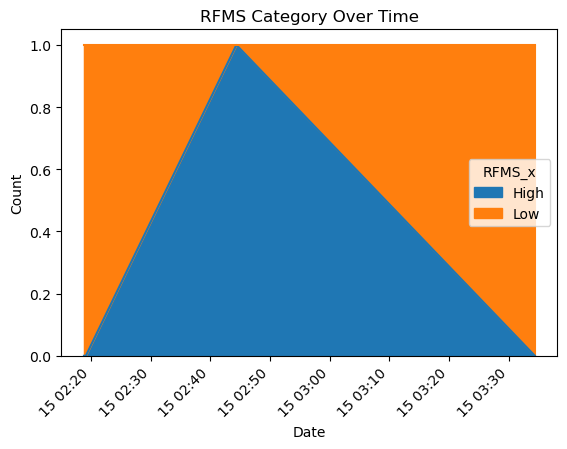

In [66]:
# Group the data by TransactionStartTime_x and RFMS_x, and calculate the count for each combination
rfms_over_time = train_merged.groupby(['TransactionStartTime_x', 'RFMS_x']).size().unstack()

# Create an area plot
plt.figure(figsize=(8, 6))
rfms_over_time.plot(kind='area', stacked=True)
plt.title('RFMS Category Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

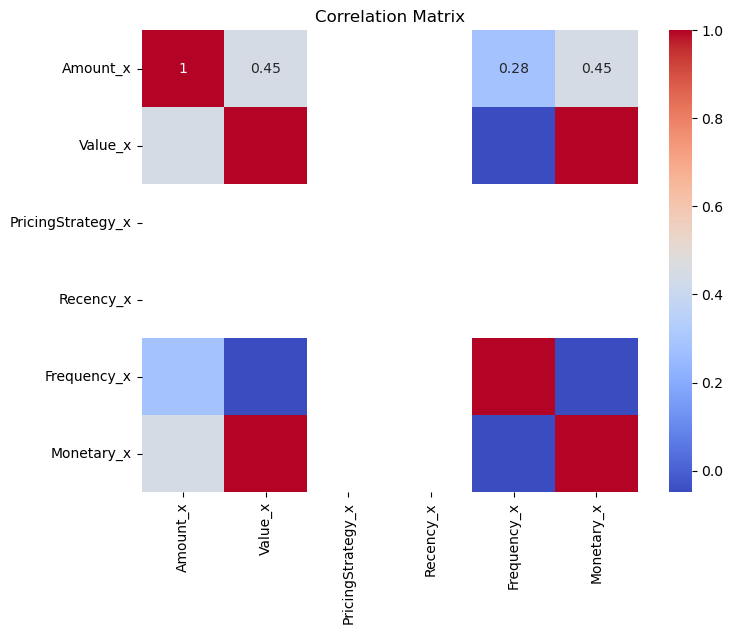

In [67]:
# Create a correlation matrix of numeric columns
numeric_columns = ['Amount_x', 'Value_x', 'PricingStrategy_x', 'Recency_x', 'Frequency_x', 'Monetary_x']
correlation_matrix = train_merged[numeric_columns].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()